In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
def f(x):
    return 3*x**2 - 4*x +5

In [83]:
f(3)

20

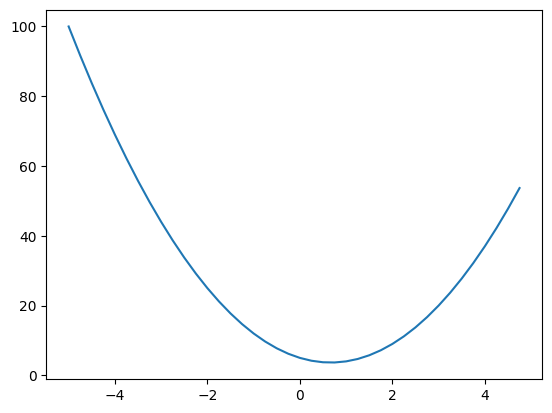

In [84]:
xs = np.arange(-5,5,0.25)
ys= f(xs)
plt.plot(xs,ys)

### Derivative , L = f(x+h) -f(x) / h

In [85]:
h = 0.000001
x = -3.0
(f(x+h) - f(x))/h

-21.999997002808414

In [86]:
h = 0.001
a = 2.0 
b = -3.0
c = 10.0
d1 = a*b + c
b+=h
d2 = a*b + c
print('slope ',(d2-d1)/h)

slope  1.9999999999997797


In [134]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children) #maintain in class we use set(for efficiency)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data , (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other): #self - other
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data ,(self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += out.grad * other * (self.data ** (other-1))
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other): # other *self
        return self * other
    
    def __truediv__(self,other): # self/other
        return self * (other**-1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,) ,'tanh')
        
        def _backgrad():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backgrad
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        
        def _backward():
            self.grad += out.grad * out.data
        out._backward=_backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self) 
        
        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [135]:
a=Value(4)
b=Value(2)
a/b

Value(2.0)

In [136]:
a = Value(2.0,label='a')
b = Value(-3.0 , label='b')
c = Value(10.0,label = 'c')
e = a+b ; e.label='e'
d = e + c ; d.label='d'
f = Value(-2.0,label='f')
L = d*f ; L.label="L"
L

Value(-18.0)

In [137]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

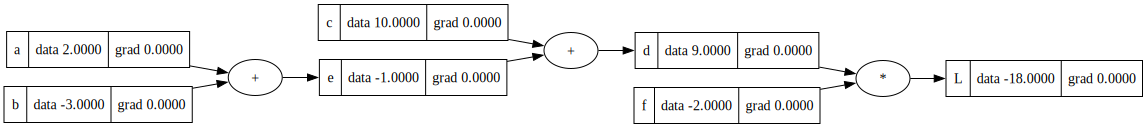

In [138]:
draw_dot(L)

In [139]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0,label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0,label = 'c')
    e = a*b ; e.label='e'
    d = e + c ; d.label='d'
    f = Value(-2.0,label='f')
    L = d*f ; L.label="L"
    L1=L.data
    
    a = Value(2.0 + h,label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0,label = 'c')
    e = a*b ; e.label='e'
    d = e + c ; d.label='d'
    f = Value(-2.0,label='f')
    L = d*f ; L.label="L"
    L2=L.data
    
    print((L2-L1)/h)

lol()

6.000000000021544


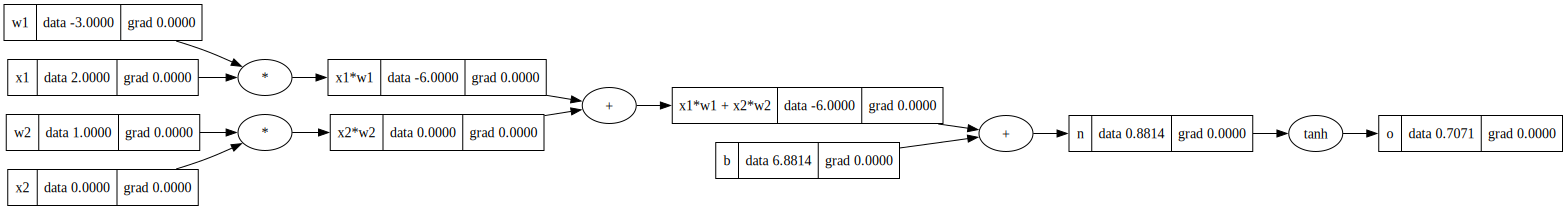

In [140]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

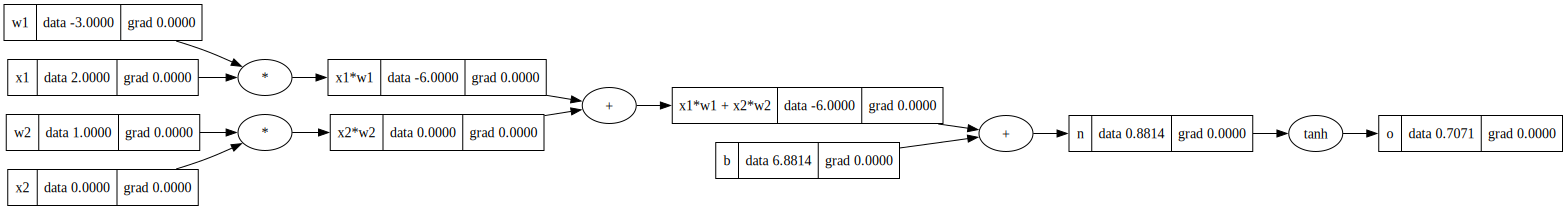

In [141]:
draw_dot(o)

In [94]:
o.backward()

In [95]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
        
build_topo(o) 

for node in reversed(topo):
    node._backward()

In [96]:
topo

[Value(6.881373587019543),
 Value(-3.0),
 Value(2.0),
 Value(-6.0),
 Value(1.0),
 Value(0.0),
 Value(0.0),
 Value(-6.0),
 Value(0.8813735870195432),
 Value(0.7071067811865476)]

In [97]:
n._backward()

In [98]:
x1w1x2w2._backward()

In [99]:
# o.grad = 0
# # do/dn = 1 - (tanhn)**2 = (1 - o**2)
# n.grad = 1 - (o.data **2)
# x1w1x2w2.grad = 0.5
# b,grad = 0.5


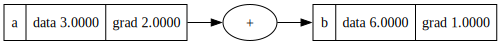

In [100]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

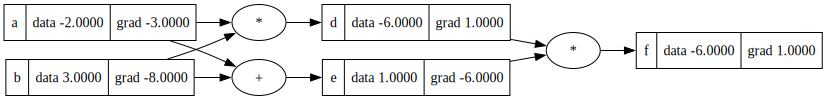

In [101]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

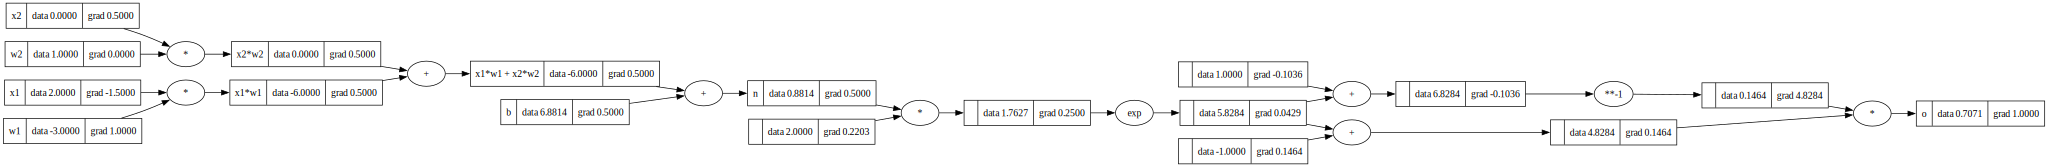

In [144]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [146]:
import torch

In [147]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
